## Prepare Dataset

In [1]:
import sys
sys.path.insert(1, '../datasets/')
from fasion_mnist import Dataset, DataLoader, TestDataloader
from fasion_mnist import IMAGE_SIZE, CHANNELS, BATCH_SIZE
dataset = Dataset()
dataloader = DataLoader()
test_dataloader = TestDataloader()

Found cached dataset fashion_mnist (/users/lukemk/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

## Prepare Models

In [2]:
import importlib
import deq_model #import the module here, so that it can be reloaded.
importlib.reload(deq_model)
from deq_model import DEQ # or whatever name you want.

In [3]:
import importlib
import deq_solvers #import the module here, so that it can be reloaded.
importlib.reload(deq_solvers)
from deq_solvers import anderson # or whatever name you want.

In [4]:
import torch
from torch.optim import Adam
from deq_model import DEQ

device = "cuda:2" if torch.cuda.is_available() else "cpu"
model = DEQ(solver_type="anderson", channels = CHANNELS, n_channels=48, n_inner_channels=64, num_groups=8).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

## Hyper-parameters

In [5]:
save_and_sample_every = 1000
timesteps = 200
scheduler_type = "linear"

from pathlib import Path
from schedulers import Scheduler, LinearScheduler, CosineScheduler, ExponentialScheduler
scheduler = Scheduler(scheduler_type, timesteps = timesteps)

ImportError: cannot import name 'ExponentialScheduler' from 'schedulers' (/work/lukemk/xingjian/DEQ_Diffusion/DEQ_Diffusion/src/schedulers.py)

## Evaluation

In [8]:
from torchvision.utils import save_image
from samplers import sample
from losses import p_losses
from utils import num_to_groups
from torch.utils.data import DataLoader, random_split
import time

import random
def evaluate (model):
    model.eval()
    total_loss = []
    start_time = time.time()
    
    for step, batch in enumerate(test_dataloader):
        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"].to(device)
        t = torch.randint(0, scheduler.timesteps, (batch_size,), device=device).long()
        loss = p_losses(model, scheduler, batch, t, loss_type="huber")
        total_loss += [loss.item()]

    model.train()
    end_time = time.time()
    mean_loss = sum(total_loss) / len(total_loss)
    print(f'eval loss {mean_loss}, with run time {end_time - start_time}')
    return mean_loss

In [107]:
deq = []
for i in range (10):
    name = f'../weights/fasion_mnist_DEQ_anderson_12_time_ep{i}.pkl'
    model.load_state_dict(torch.load(name))
    loss = evaluate(model)
    deq.append(loss)

import pickle
with open('../stats/fasion_mnist_DEQ_anderson_48_time.pkl', 'wb') as f:
    pickle.dump(deq, f)

eval loss 0.04165929447435125, with run time 15.273667335510254
eval loss 0.03961047900345507, with run time 25.29602074623108
eval loss 0.04116637712415261, with run time 29.61703872680664
eval loss 0.03881879499818705, with run time 29.841381311416626
eval loss 0.03732346050158332, with run time 29.994572401046753
eval loss 0.03867110895299459, with run time 29.913647174835205
eval loss 0.03644916655707963, with run time 29.994795322418213
eval loss 0.03864457760053345, with run time 30.03189182281494
eval loss 0.03919596265105507, with run time 30.0868136882782
eval loss 0.037534197886722, with run time 30.09326672554016


## Training

In [7]:
from torchvision.utils import save_image
from samplers import sample
from losses import p_losses
from utils import num_to_groups

def train (model, optimizer, scheduler, dataloader = dataloader, epochs=5, channels=CHANNELS):
    for epoch in range(epochs):
        epoch_loss = []
        for step, batch in enumerate(dataloader):
            batch_size = batch["pixel_values"].shape[0]
            optimizer.zero_grad()
            batch = batch["pixel_values"].to(device)

            # Algorithm 1 line 3: sample t uniformally for every example in the batch
            t = torch.randint(0, scheduler.timesteps, (batch_size,), device=device).long()

            loss = p_losses(model, scheduler, batch, t, loss_type="huber")
            epoch_loss.append(loss.item())

            if step % 30 == 0:
                print("loss:", sum(epoch_loss) / len(epoch_loss), 'at step', step, ' out of ', len(dataloader))

            loss.backward()
            optimizer.step()

            # save generated images
            if step != 0 and step % save_and_sample_every == 0:
                milestone = step // save_and_sample_every
                batches = num_to_groups(4, batch_size)
                all_images_list = list(map(lambda n: sample(model, scheduler, batch_size=n, channels=channels), batches))
                all_images = torch.cat(all_images_list, dim=0)
                all_images = (all_images + 1) * 0.5
                save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)
        print(f'Loss after epoch {epoch}: {sum(epoch_loss) / len(epoch_loss)}')
        torch.save(model.state_dict(), f'../weights/fasion_mnist_DEQ_anderson_12_time_ep{epoch}.pkl')


In [ ]:
train(model, optimizer, scheduler)

## Visualize & Eval

In [11]:
from samplers import sample
%matplotlib inline
import matplotlib.pyplot as plt
from random import randrange
import matplotlib.animation as animation
import os

def make_animation(samples, scheduler, index, name_prefix = ""):
    fig = plt.figure()
    ims = []
    for i in range(scheduler.timesteps):
        im = plt.imshow(samples[i][index].reshape(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), cmap="gray", animated=True)
        ims.append([im])
    animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    
    id = 0
    while os.path.exists(f'../gifs/{name_prefix}_{id}.gif'):
        id += 1
    animate.save(f'../gifs/{name_prefix}_{id}.gif')
    plt.show()

def visualize (model, scheduler, gif_num = 1, side_num = 4, name_prefix = ""):
    samples = sample(model, scheduler, image_size=IMAGE_SIZE, batch_size = side_num * side_num, channels=CHANNELS)
    
    f, axarr = plt.subplots(side_num, side_num)
    for i in range(side_num):
        for j in range(side_num):
            axarr[i,j].imshow(samples[-1][i * side_num + j].reshape(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), cmap="gray")
    plt.show()

    # bottleneck is here
    for i in range(gif_num):
        make_animation(samples, scheduler, i, name_prefix = name_prefix)

In [12]:
name = f'../weights/fasion_mnist_DEQ_anderson_12_time_ep{9}.pkl'
model.load_state_dict(torch.load(name))

<All keys matched successfully>

sampling loop time step: 100%|██████████| 200/200 [00:10<00:00, 18.53it/s]


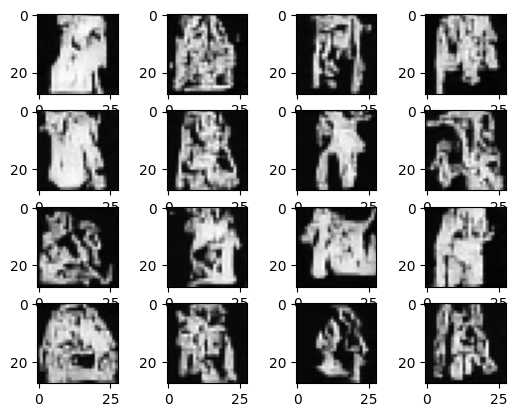

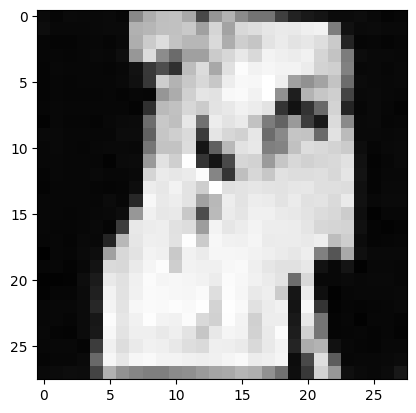

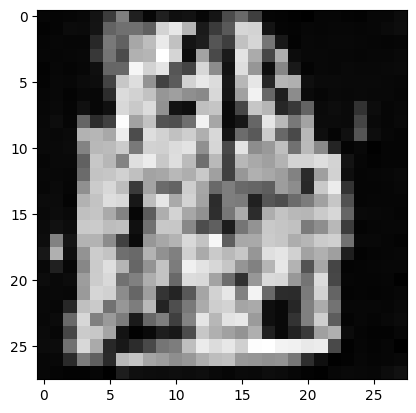

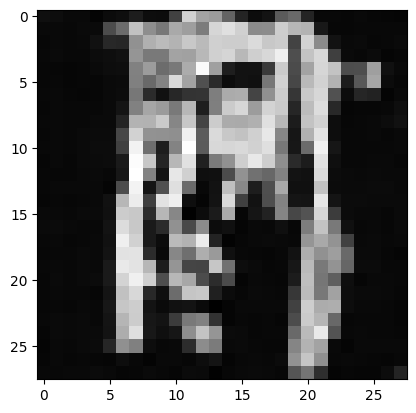

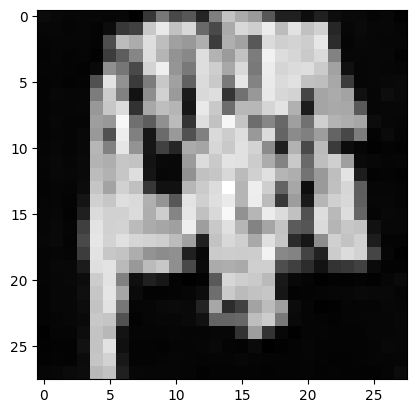

In [13]:
visualize(model, LinearScheduler(), gif_num = 4, side_num = 4, name_prefix = "DEQ_anderson_again")

sampling loop time step: 100%|██████████| 200/200 [00:12<00:00, 16.52it/s]


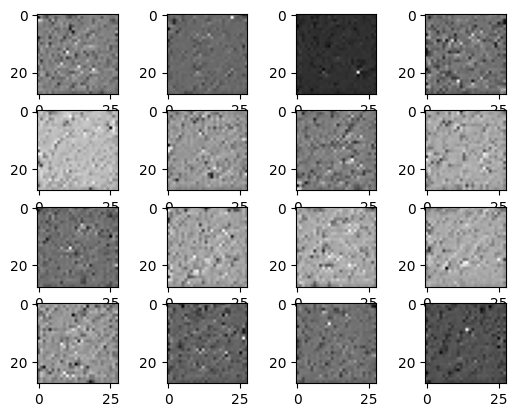

In [9]:
visualize(model, CosineScheduler(), gif_num = 0, side_num = 4, name_prefix = "DEQ_anderson_again")